In [0]:
import numpy as np
import pandas as pd
import os
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from torch.autograd import Variable

from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import seaborn as sns
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.set_default_tensor_type('torch.DoubleTensor')

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/data')

Drive already mounted at /content/data; to attempt to forcibly remount, call drive.mount("/content/data", force_remount=True).


In [0]:
os.chdir('/content/data/My Drive/DL_Assignment_2')

In [0]:
Data = pd.read_csv('./Data_2/data.csv',delimiter = ',',header = None)
labels = pd.read_csv('./Data_2/label.csv',delimiter = ',',header = None)

In [5]:
Data.shape

(35000, 785)

In [0]:
X = np.array(Data.iloc[:, 0:784])
Y = np.array(Data.iloc[:, 784])

#train,test splt
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state=0)

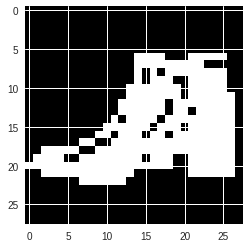

In [7]:
plt.imshow(X[4101].reshape(28,28))

In [8]:
labels

,0
0,Ankle boot
1,T-shirt/top
2,Shirt
3,Dress
4,Trouser


In [9]:
Y[3]

3

In [0]:
mapping = {'Ankle boot':0,'T-shirt/top':1,'Shirt':2,'Dress':3,'Trouser':4}

In [0]:
class RBM(nn.Module):
    def __init__(self, v_size, h_size,k):
        super(RBM, self).__init__()

        self.v_to_h = nn.Sequential(
            nn.Linear(v_size, h_size),
            nn.Sigmoid()
        )
        self.h_to_v = nn.Sequential(
            nn.Linear(h_size, v_size)
        )
        
        self.k = k
    def forward(self, v):
        visible = v.double()
        for i in range(self.k):
        
          hidden = self.v_to_h(visible)
          visible = self.h_to_v(hidden)
        return visible, hidden
      
def RBM_Model(x, v_size, h_size, k):
 
  dtype = torch.int64
  
  print("hidden layer size : ",h_size)
  print('***********************************')
  x_torch = torch.tensor(x); 
  x_torch = x_torch.to(device)
  

  v_size = v_size
  h_size = h_size
  k = k
  MAX_EPOCH = 1000
  BATCH_SIZE = 2048
  LR = 1e-4        
  ERROR_THRESHOLD = 1e-4

  train_loader = torch.utils.data.DataLoader(x_torch, batch_size = BATCH_SIZE, shuffle=False)


  model = RBM(v_size, h_size, k)
  model = model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=LR)
  loss_fn = torch.nn.MSELoss(reduction='mean')
  error_train = []
  for epoch in range(MAX_EPOCH):
      batch_loss = []
      for data in train_loader: 
        
        data = data.double()

        visible, hidden = model(data)
        visible = visible.double()

        loss = loss_fn(visible, data)

        batch_loss.append(loss.item())
        optimizer.zero_grad()               
        loss.backward()                     
        optimizer.step()  
       
      mean_batch_loss = np.mean(batch_loss)
      del batch_loss
      if epoch % 100 == 0:
          print(epoch, mean_batch_loss.item())    
      error_train.append(mean_batch_loss.item())

      if  epoch>= 5 and abs(error_train[epoch-4] - error_train[epoch]) <= ERROR_THRESHOLD:
        print('Reached threshold')
        break     
  plt.plot(error_train, color = 'g', label = 'reconstruction error')
  plt.legend()

  plt.xlabel('epochs')
  plt.ylabel('Likelihood')
  plt.title('Likelihood vs epochs')
  plt.show()
  
  print('***********************************')
  print('number of epochs:', len(error_train))
  print('reconstruction error: ', error_train[-1])
  print('***********************************')
  print('***********************************')
  
  _ , x_rbm = model(x_torch)
  x_rbm = x_rbm.cpu().detach()
  
  
  return model,x_rbm

hidden layer size :  300
***********************************
0 0.6582151681879429
Reached threshold


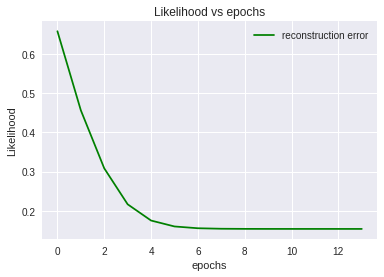

***********************************
number of epochs: 14
reconstruction error:  0.15339635615019034
***********************************
***********************************


In [0]:
model,x_rbm = RBM_Model(x_train, x_train.shape[1], 300, k=5)

In [0]:
def Stacked_RBM_Models(x_train,h_size,k):
  
  k = k
  v_size = x_train.shape[1]
  
  h_size_1 = h_size
  h_size_2 = int(h_size_1 * 0.5)
  h_size_3 = int(h_size_2 * 0.5)
  
  RBM1, feat1 = RBM_Model(x_train,v_size, h_size_1, k)
  RBM2, feat2 = RBM_Model(feat1, h_size_1, h_size_2, k)
  RBM3, feat3 = RBM_Model(feat2, h_size_2, h_size_3, k)
  
  
  
  return RBM1,RBM2,RBM3,feat3,h_size_3

def Stacked_RBMSs(h_size,k):
  
  k = k
  v_size = 784
  
  h_size_1 = h_size
  h_size_2 = int(h_size_1 * 0.5)
  h_size_3 = int(h_size_2 * 0.5)
  
  print('Hidden layer-1 : ',h_size_1)
  print('Hidden layer-2 : ',h_size_2)
  print('Hidden layer-3 : ',h_size_3)
  
  RBM1 = RBM(v_size, h_size_1, k)
  RBM2 = RBM(h_size_1, h_size_2, k)
  RBM3 = RBM(h_size_2, h_size_3, k)
  
  
  return RBM1,RBM2,RBM3,h_size_3 

hidden layer size :  300
***********************************
0 0.6393528901977112
Reached threshold


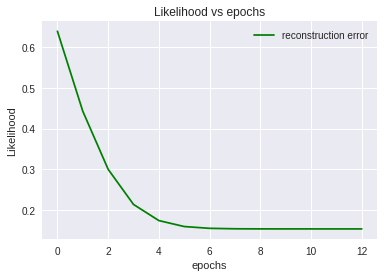

***********************************
number of epochs: 13
reconstruction error:  0.15339727303165054
***********************************
***********************************
hidden layer size :  210
***********************************


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0 0.5616273684232138
Reached threshold


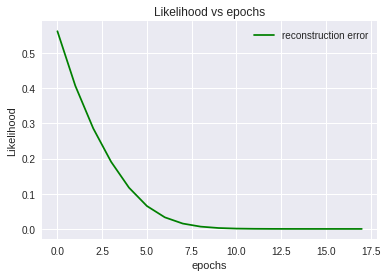

***********************************
number of epochs: 18
reconstruction error:  1.0400258392390428e-07
***********************************
***********************************
hidden layer size :  147
***********************************
0 0.47026063416502845
Reached threshold


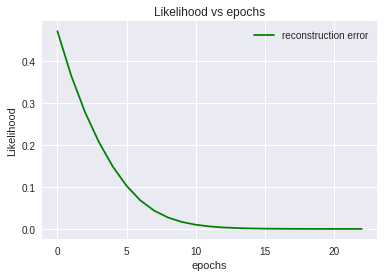

***********************************
number of epochs: 23
reconstruction error:  5.912631255044277e-06
***********************************
***********************************


In [0]:
RBM1,RBM2,RBM3,feat3 = Stacked_RBM_Models(x_train,300,5)

In [0]:
################# MLFFNN  #########################
def heat_map(actual_train,predicted_train,actual_test,predicted_test):
    import seaborn as sn
    import pandas as pd
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    
    labels = ["Ankle boot","T-shirt/top","Shirt","Dress","Trouser"]
    cm1 =confusion_matrix(actual_train,predicted_train)
    df_cm1 = pd.DataFrame(cm1, index=labels, columns=labels)
                         
    cm2 =confusion_matrix(actual_test,predicted_test)
    df_cm2 = pd.DataFrame(cm2, index=labels, columns=labels)
    
    fig1 = plt.figure(1)
    
    #sn.set(font_scale=1.4)
    sn.heatmap(df_cm1, cmap="YlGnBu",annot=True,fmt='.0f',annot_kws={"size": 12})
    plt.yticks(rotation=0)
    
    fig2 = plt.figure(2)
    #sn.set(font_scale=1.4)
    sn.heatmap(df_cm2, cmap="YlGnBu",annot=True,fmt='.0f',annot_kws={"size": 12})
    plt.yticks(rotation=0)
    
    plt.show()
class ConcatDataset(torch.utils.data.Dataset):
    def __init__(self, *datasets):
        self.datasets = datasets

    def __getitem__(self, i):
        return tuple(d[i] for d in self.datasets)

    def __len__(self):
        return min(len(d) for d in self.datasets)

def StackedRBM_MLFFNN(x_train, y_train, x_test, y_test, learning_rate, max_epoch, error_threshold, h_size, k): 
  
  dtype = torch.int64

  #make torch tensors 
  x_train_torch = torch.tensor(x_train,dtype=torch.double); 
  x_train_torch = x_train_torch.to(device)
  y_train_torch = torch.tensor(y_train, dtype=dtype)
  y_train_torch = y_train_torch.to(device)
  
  x_test_torch = torch.tensor(x_test,dtype=torch.double); 
  x_test_torch = x_test_torch.to(device)
  y_test_torch = torch.tensor(y_test, dtype=dtype)
  y_test_torch = y_test_torch.to(device)
  
  k = k
  D_IN = x_train.shape[1]
  HIDDEN_SIZE = h_size
  D_OUT = 5
  LEARNING_RATE = learning_rate
  MAX_EPOCH = max_epoch
  THRESHOLD = error_threshold
  
  RBM1,RBM2,RBM3,feature_train_rbm, h_size3 = Stacked_RBM_Models(x_train, HIDDEN_SIZE, k)
  
  
  
  train_loader = torch.utils.data.DataLoader(ConcatDataset(x_train_torch,y_train_torch), batch_size= 2048, shuffle=False)
  
  classifier = torch.nn.Sequential(RBM1.v_to_h,RBM2.v_to_h,RBM3.v_to_h,torch.nn.Linear(h_size3, 5),
                                   torch.nn.Softmax())
         

  classifier = classifier.to(device)
  loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
  optimizer = torch.optim.Adam(classifier.parameters(), lr=LEARNING_RATE)
  error_train = []
  accuracy = []
  ##### Training ##############
  for epoch in range(MAX_EPOCH):
    batch_loss = []
    for data in train_loader: 
    
    
      y_pred_train = classifier(x_train_torch)        
      loss_train = loss_fn(y_pred_train, y_train_torch)
      batch_loss.append(loss_train.item())
      
      optimizer.zero_grad()
      loss_train.backward()
      optimizer.step()
     
    ##########
    y_pred_test = classifier(x_test_torch) 
    prediction_test = y_pred_test.cpu().detach().numpy()
    prediction_test = prediction_test.argmax(axis = 1)
    acc = accuracy_score(y_test, prediction_test)
    accuracy.append(acc.item())
    ###############
    mean_batch_loss = np.mean(batch_loss)
    del batch_loss
    if epoch % 50 == 0:
        print(epoch, mean_batch_loss.item())    
    error_train.append(mean_batch_loss.item())

    #early stopping criteria
    if epoch >= 5 and abs(error_train[epoch-1] - error_train[epoch]) <= THRESHOLD:
      print('Reached threshold')
      break

  
  
  print('number of epochs:', len(error_train))
  print('train error: ', error_train[-1])
  #test accuracy
  y_pred_test = classifier(x_test_torch)        
  loss_test = loss_fn(y_pred_test, y_test_torch)
  test_error = loss_test.cpu().item()
  print('test error: ', test_error)
  
  #fig1 = plt.figure(1)
  plt.plot(error_train, color = 'b', label = 'training error pre trained')
  plt.legend()
  plt.xlabel('epochs')
  plt.ylabel('cross entropy')
  plt.title('cross entropy vs epochs')
  plt.show()
  
  #fig2 = plt.figure(2)
  
  prediction_train = y_pred_train.cpu().detach().numpy()
  prediction_train = prediction_train.argmax(axis = 1)
  acc = accuracy_score(y_train, prediction_train)
  fig3 = plt.figure(3)
  print('Train accuracy:', acc)

  
  ##################
  prediction_test = y_pred_test.cpu().detach().numpy()
  prediction_test = prediction_test.argmax(axis = 1)
  acc = accuracy_score(y_test, prediction_test)
  print('Test accuracy:', acc)

  #Confusion matrix
  heat_map(y_train, prediction_train, y_test, prediction_test)

  return classifier,accuracy,error_train

hidden layer size :  75
***********************************
0 0.7510890101662201
Reached threshold


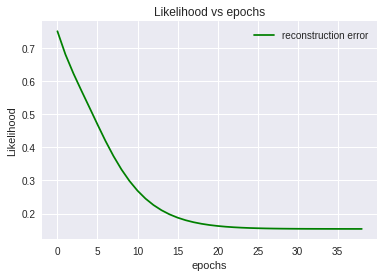

***********************************
number of epochs: 39
reconstruction error:  0.15342262650069358
***********************************
***********************************
hidden layer size :  37
***********************************
0 0.8532741762362982


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Reached threshold


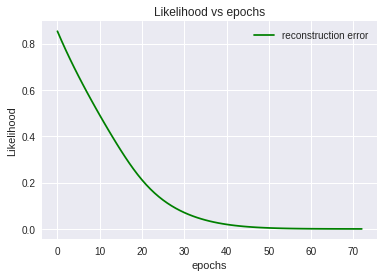

***********************************
number of epochs: 73
reconstruction error:  8.203139385390414e-05
***********************************
***********************************
hidden layer size :  18
***********************************
0 0.805925837330784
100 0.0034618409531955766
Reached threshold


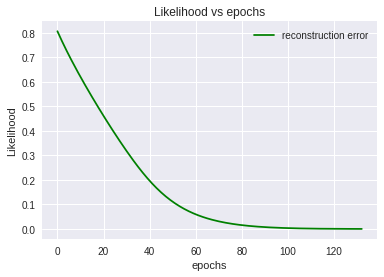

***********************************
number of epochs: 133
reconstruction error:  0.00019277119503134088
***********************************
***********************************


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 1.61089073579884
50 1.5243415092517643
100 1.4165753558412237
150 1.355865120120664
200 1.3149160859842788
250 1.2330554355508823
300 1.142057568864834
350 1.0856577397883749
400 1.0480775880344209
450 1.0215520434060885
500 1.0018261309666527
550 0.9875324270309851
600 0.9764548432632244
650 0.9678724036952161
700 0.9615159807309999
750 0.9565591413990782
800 0.9526409549894922
850 0.9496797899900059
900 0.9478225421904386
950 0.9464128106002012
1000 0.9451848523910323
1050 0.9443410206955297
1100 0.9433318360018751
1150 0.9426945721580049
1200 0.9420656232472896
1250 0.9417377597113195
1300 0.9414572999833187
1350 0.9412628236412116
1400 0.9410720014881407
1450 0.9409085081334202
number of epochs: 1500
train error:  0.9408124906562452
test error:  1.0221981814535335


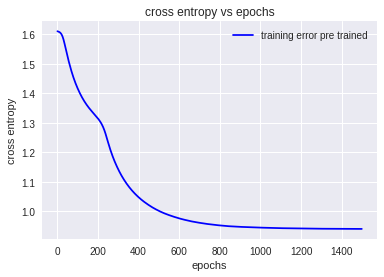

Train accuracy: 0.9637959183673469
Test accuracy: 0.8819047619047619


<Figure size 432x288 with 0 Axes>

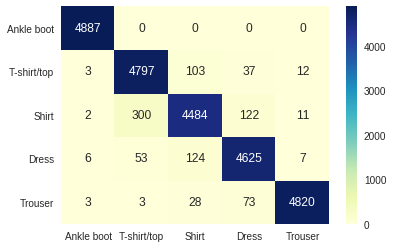

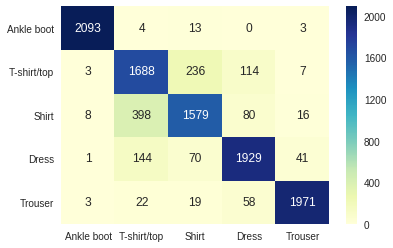

In [25]:
classifier,accuracy,error_train= StackedRBM_MLFFNN(x_train, y_train, x_test, y_test, 
                                                    learning_rate = 1e-4, max_epoch=1500, 
                                                    error_threshold = 0, h_size = 75, k = 5)

In [0]:
################# MLFFNN  #########################
def heat_map(actual_train,predicted_train,actual_test,predicted_test):
    import seaborn as sn
    import pandas as pd
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    
    labels = ["Ankle boot","T-shirt/top","Shirt","Dress","Trouser"]
    cm1 =confusion_matrix(actual_train,predicted_train)
    df_cm1 = pd.DataFrame(cm1, index=labels, columns=labels)
                         
    cm2 =confusion_matrix(actual_test,predicted_test)
    df_cm2 = pd.DataFrame(cm2, index=labels, columns=labels)
    
    fig1 = plt.figure(1)
    
    #sn.set(font_scale=1.4)
    sn.heatmap(df_cm1, cmap="YlGnBu",annot=True,fmt='.0f',annot_kws={"size": 12})
    plt.yticks(rotation=0)
    
    fig2 = plt.figure(2)
    #sn.set(font_scale=1.4)
    sn.heatmap(df_cm2, cmap="YlGnBu",annot=True,fmt='.0f',annot_kws={"size": 12})
    plt.yticks(rotation=0)
    
    plt.show()
class ConcatDataset(torch.utils.data.Dataset):
    def __init__(self, *datasets):
        self.datasets = datasets

    def __getitem__(self, i):
        return tuple(d[i] for d in self.datasets)

    def __len__(self):
        return min(len(d) for d in self.datasets)

def Simple_MLFFNN(x_train, y_train, x_test, y_test, learning_rate, max_epoch, error_threshold, h_size, k): 
  
  dtype = torch.int64

  #make torch tensors 
  x_train_torch = torch.tensor(x_train,dtype=torch.double); 
  x_train_torch = x_train_torch.to(device)
  y_train_torch = torch.tensor(y_train, dtype=dtype)
  y_train_torch = y_train_torch.to(device)
  
  x_test_torch = torch.tensor(x_test,dtype=torch.double); 
  x_test_torch = x_test_torch.to(device)
  y_test_torch = torch.tensor(y_test, dtype=dtype)
  y_test_torch = y_test_torch.to(device)
  
  k = k
  D_IN = x_train.shape[1]
  HIDDEN_SIZE = h_size
  D_OUT = 5
  LEARNING_RATE = learning_rate
  MAX_EPOCH = max_epoch
  THRESHOLD = error_threshold
  
  RBM1,RBM2,RBM3, h_size3 = Stacked_RBMSs( HIDDEN_SIZE, k)
  
  
  
  train_loader = torch.utils.data.DataLoader(ConcatDataset(x_train_torch,y_train_torch), batch_size= 2048, shuffle=False)
  
  classifier = torch.nn.Sequential(RBM1.v_to_h,RBM2.v_to_h,RBM3.v_to_h,torch.nn.Linear(h_size3, 5),
                                   torch.nn.Softmax())
         

  classifier = classifier.to(device)
  loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
  optimizer = torch.optim.Adam(classifier.parameters(), lr=LEARNING_RATE)
  error_train = []
  accuracy = []
  ##### Training ##############
  for epoch in range(MAX_EPOCH):
    batch_loss = []
    for data in train_loader: 
    
    
      y_pred_train = classifier(x_train_torch)        
      loss_train = loss_fn(y_pred_train, y_train_torch)
      batch_loss.append(loss_train.item())
      
      optimizer.zero_grad()
      loss_train.backward()
      optimizer.step()
     
    ##########
    y_pred_test = classifier(x_test_torch) 
    prediction_test = y_pred_test.cpu().detach().numpy()
    prediction_test = prediction_test.argmax(axis = 1)
    acc = accuracy_score(y_test, prediction_test)
    accuracy.append(acc.item())
    ###############
    mean_batch_loss = np.mean(batch_loss)
    del batch_loss
    if epoch % 50 == 0:
        print(epoch, mean_batch_loss.item())    
    error_train.append(mean_batch_loss.item())

    #early stopping criteria
    if epoch >= 5 and abs(error_train[epoch-1] - error_train[epoch]) <= THRESHOLD:
      print('Reached threshold')
      break

  
  
  print('number of epochs:', len(error_train))
  print('train error: ', error_train[-1])
  #test accuracy
  y_pred_test = classifier(x_test_torch)        
  loss_test = loss_fn(y_pred_test, y_test_torch)
  test_error = loss_test.cpu().item()
  print('test error: ', test_error)
  
  #fig1 = plt.figure(1)
  plt.plot(error_train, color = 'b', label = 'training error pre trained')
  plt.legend()
  plt.xlabel('epochs')
  plt.ylabel('cross entropy')
  plt.title('cross entropy vs epochs')
  plt.show()
  
  #fig2 = plt.figure(2)
  
  prediction_train = y_pred_train.cpu().detach().numpy()
  prediction_train = prediction_train.argmax(axis = 1)
  acc = accuracy_score(y_train, prediction_train)
  fig3 = plt.figure(3)
  print('Train accuracy:', acc)

  
  ##################
  prediction_test = y_pred_test.cpu().detach().numpy()
  prediction_test = prediction_test.argmax(axis = 1)
  acc = accuracy_score(y_test, prediction_test)
  print('Test accuracy:', acc)

  #Confusion matrix
  heat_map(y_train, prediction_train, y_test, prediction_test)

  return classifier,accuracy,error_train

Hidden layer-1 :  75
Hidden layer-2 :  37
Hidden layer-3 :  18


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 1.6102709732639628
50 1.4872572487792997
100 1.4364696154434287
150 1.388491956984925
200 1.34281144106653
250 1.2949701636741826
300 1.2452963237644317
350 1.2031582759584312
400 1.1745287587497946
450 1.1517851928448357
500 1.121226658701058
550 1.0905941342496066
600 1.0635792922282732
650 1.0407481689558165
700 1.021999146051791
750 0.9966004318581132
800 0.9831116377174421
850 0.9733293108402442
900 0.9653133908412949
950 0.957820131537911
1000 0.9520657727522973
1050 0.9480488126439651
1100 0.9451193274150826
1150 0.9428478439180706
1200 0.9409043135887103
1250 0.9393671113510828
1300 0.9377889252290704
1350 0.9363665269454212
1400 0.9351569362045072
1450 0.9343128375937507
number of epochs: 1500
train error:  0.9336826942333221
test error:  1.0230859533019225


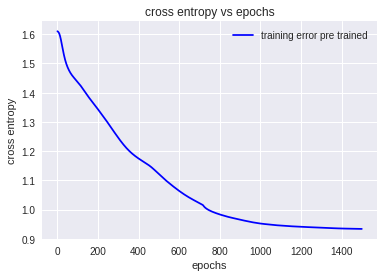

Train accuracy: 0.9723265306122449
Test accuracy: 0.882


<Figure size 432x288 with 0 Axes>

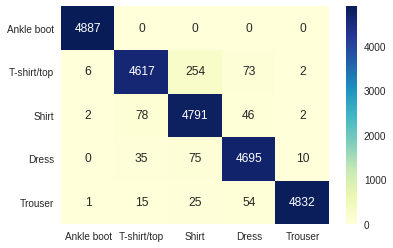

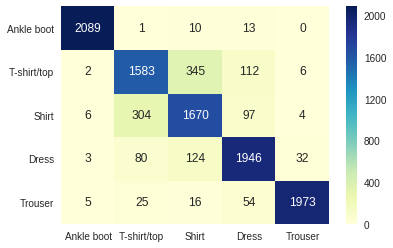

In [26]:
classifier,accuracy1,error_train1= Simple_MLFFNN(x_train, y_train, x_test, y_test, 
                                                    learning_rate = 1e-4, max_epoch=1500, 
                                                    error_threshold = 0, h_size = 75, k=5)

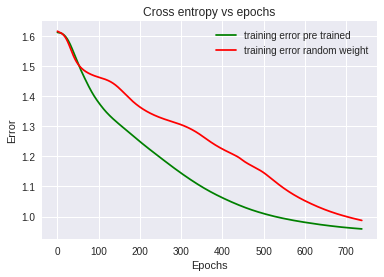

In [22]:
plt.plot(error_train,  color = 'g', label = 'training error pre trained')
plt.plot(error_train1[0:len(error_train)], color = 'r', label = 'training error random weight')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Cross entropy vs epochs')
plt.show()

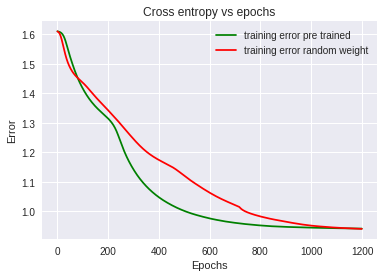

In [29]:
plt.plot(error_train[0:1200],  color = 'g', label = 'training error pre trained')
plt.plot(error_train1[0:1200], color = 'r', label = 'training error random weight')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Cross entropy vs epochs')
plt.show()

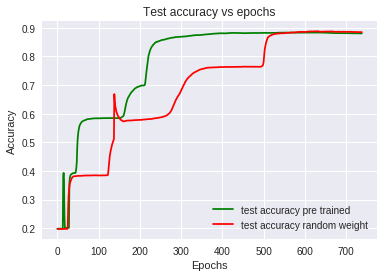

In [21]:
plt.plot(accuracy, color = 'g', label = 'test accuracy pre trained')
plt.plot(accuracy1[0:len(accuracy)], color = 'r', label = 'test accuracy random weight')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test accuracy vs epochs')
plt.show()

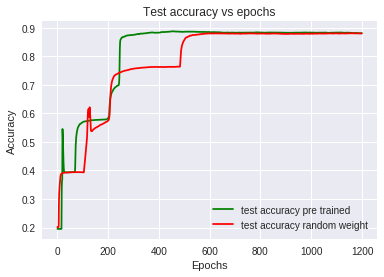

In [30]:
plt.plot(accuracy[0:1200], color = 'g', label = 'test accuracy pre trained')
plt.plot(accuracy1[0:1200], color = 'r', label = 'test accuracy random weight')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test accuracy vs epochs')
plt.show()